<a id="top"></a>
# Cloud-Filtered Custom Mosaics

<hr><hr>

# Notebook Summary

This notebook can be used to create custom Landsat cloud-filtered mosaics for any time period and location. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. The following mosaics are possible:

Median = midpoint of spectral data
Geomedian = Australian median product with improved spectral consistency
Most-Recent = most-recent clear pixel
Max-NDVI = maximum vegetation response

Users should review the ["Cloud_Statistics" notebook](DCAL_Cloud_Statistics.ipynb) for more information about the cloud statistics for any given temporal and spatial combination. An understanding of the underlying data is important for creating a valid mosaic for further analyses.

<hr><hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load and Clean Data from the Data Cube](#load_data)
* [Create Mosaics](#mosaics)
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Enable importing of utilities.
import sys
sys.path.append('..')

# Supress Warnings.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
8,LANDSAT_7,ls7_collections_sr_scene
67,LANDSAT_7,ls7_collections_sr_scene_lean
78,LANDSAT_7,ls7_collections_sr_scene_mini
19,LANDSAT_7,ls7_ledaps_amazon_river
20,LANDSAT_7,ls7_ledaps_bangladesh
35,LANDSAT_7,ls7_ledaps_bangladesh_bari
87,LANDSAT_7,ls7_ledaps_caqueta
21,LANDSAT_7,ls7_ledaps_colombia
22,LANDSAT_7,ls7_ledaps_ghana


In [3]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
9,LANDSAT_8,ls8_collections_sr_scene
69,LANDSAT_8,ls8_collections_sr_scene_lean
86,LANDSAT_8,ls8_lasrc_caqueta
73,LANDSAT_8,ls8_lasrc_honduras
32,LANDSAT_8,ls8_lasrc_lake_chad_full
33,LANDSAT_8,ls8_lasrc_meta_river
70,LANDSAT_8,ls8_lasrc_samoa
83,LANDSAT_8,ls8_lasrc_swiss_mini
77,LANDSAT_8,ls8_lasrc_switzerland


**Choose product**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = "ls7_ledaps_kenya"
# platform = "LANDSAT_7"

# product = "ls8_lasrc_kenya"
# platform = "LANDSAT_8"

# product = "ls7_ledaps_tanzania"
# platform = "LANDSAT_7"

# product = "ls7_ledaps_sierra_leone"
# platform = "LANDSAT_7"

# product = "ls8_lasrc_ghana"
# platform = "LANDSAT_8"

product = "ls7_ledaps_vietnam"
platform = "LANDSAT_7"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [5]:
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (9.1762906272858, 13.964939912344285)
Longitude Extents: (102.4041694654867, 108.9310588253174)
Time Extents: ['1999-09-08', '2016-12-29']


**Visualize the available area**

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Mombasa, Kenya
# latitude = (-4.1, -3.9) 
# longitude = (39.5, 39.7) 

# Freetown, Sierra Leone
# latitude = (8.3267, 8.5123)
# longitude = (-13.3109, -13.1197 )

# Tano-Offin Forest - Ghana
# latitude = (6.5814, 6.8978 ) 
# longitude = (-2.2955, -1.9395) 

# Vietnam
latitude = (10.9358, 11.0358)
longitude = (107.1899, 107.2899)

# Time Period
time_extents = ('2014-12-25', '2016-01-01')

**Visualize the selected area**

In [8]:
display_map(latitude,longitude)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>

In [9]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [10]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 371, longitude: 372, time: 19)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-09T03:06:13 ... 2015-12-27T03:08:59
  * latitude   (latitude) float64 11.04 11.04 11.04 11.03 ... 10.94 10.94 10.94
  * longitude  (longitude) float64 107.2 107.2 107.2 107.2 ... 107.3 107.3 107.3
Data variables:
    red        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 472 511
    green      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 546 526
    blue       (time, latitude, longitude) int16 -9999 -9999 -9999 ... 315 315
    nir        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 2974 3101
    swir1      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 1523 1549
    swir2      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 718 772
    pixel_qa   (time, latitude, longitude) int32 1 1 1 1 1 1 ... 66 66 66 66 66
Attributes:
    crs:      EPSG:4326

>### Masking out Clouds

In [11]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)

## <span id="mosaics">Create Mosaics [&#9652;](#top)</span>

> **Median Mosaic**  
>  Masks clouds from imagery using the median-valued cloud-free pixels in the time series.
>  More specifically, each band (e.g. red) of each pixel is assigned its median across time.
>  So this mosaic method generates values that are not in the dataset.

In [12]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
from utils.data_cube_utilities.dc_rgb import rgb

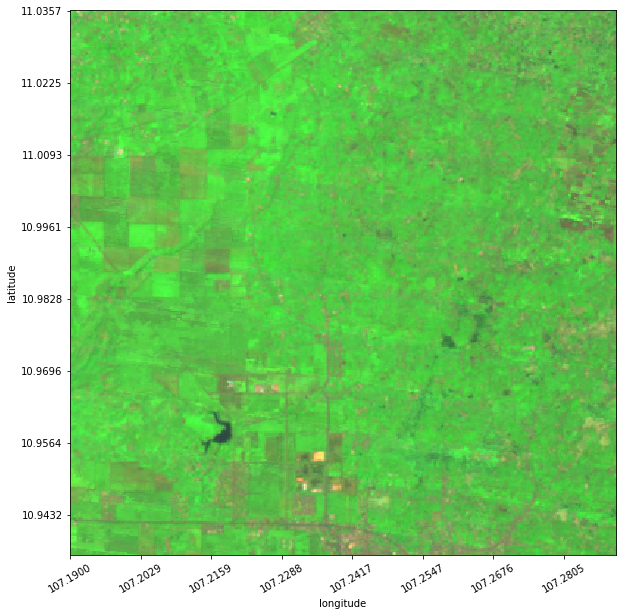

In [13]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
rgb(median_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=4000, width=10)
plt.show()

> **Geomedian Mosaic**  
>  Masks clouds from imagery using the geomedian-valued cloud-free pixels in the time series, which maintains the spectral band relationships. 
> That is, this is a median through time for all bands considered collectively rather than separately, as is the case in a median mosaic.
> This algorithm was developed by Geoscience Australia and produces excellent cloud-filtered mosaic products for further analysis. 
<br><br>
For more information, see the following paper: High-Dimensional Pixel Composites from Earth Observation Time Series, by, Dale Roberts, Norman Mueller, and Alexis McIntyre. IEEE Transactions on Geoscience and Remote Sensing, Vol. 55. No. 11, November 2017.

In [14]:
from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic

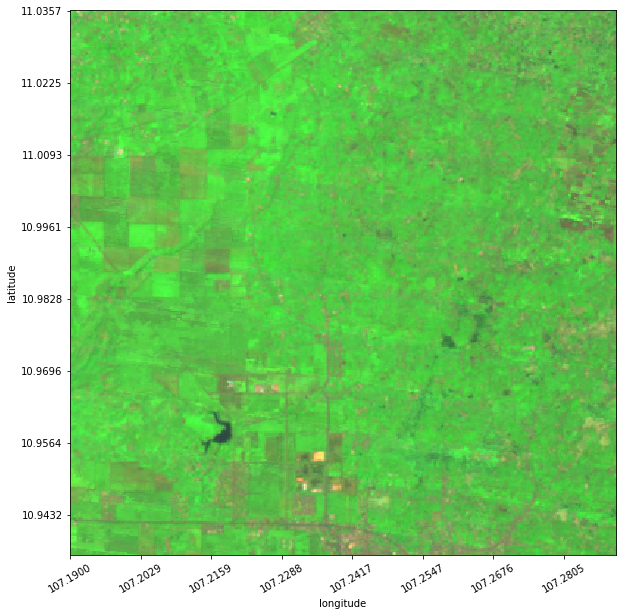

In [15]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

geomedian_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
rgb(geomedian_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=4000, width=10)
plt.show()

> **Most Recent and Least Recent Mosaic**  
>  Masks clouds from imagery using the most or least recent cloud-free pixels in the time series . 

In [16]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic

**Most Recent Mosaic**

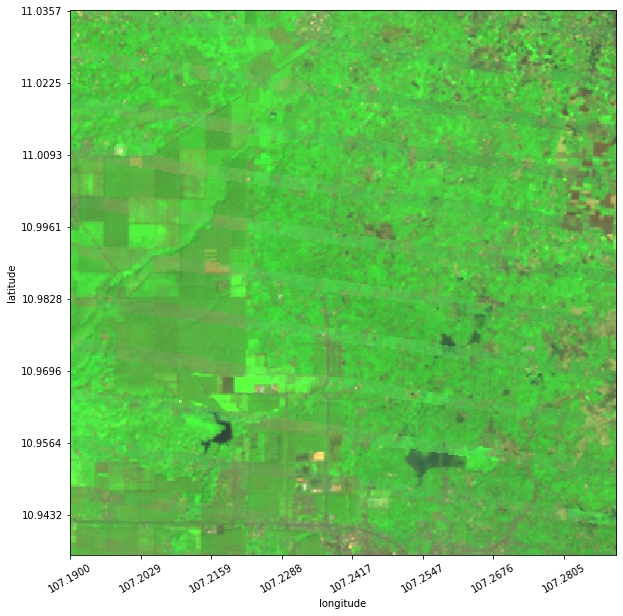

In [17]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

most_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values)
rgb(most_recent_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=4000, width=10)
plt.show()

**Least Recent Mosaic**

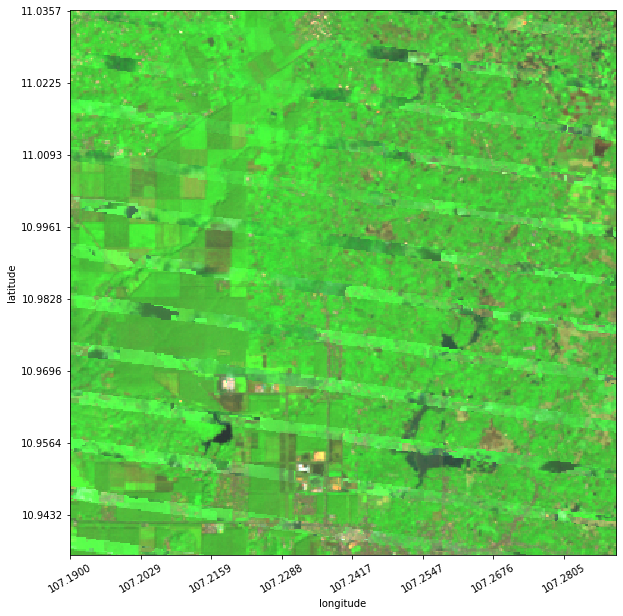

In [18]:
least_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values, reverse_time=True)
rgb(least_recent_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=4000, width=10)
plt.show()

> **Max NDVI Mosaic**  
>  Masks clouds from imagery using the Max NDVI across time for cloud-free pixels in the time series . 

In [19]:
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic

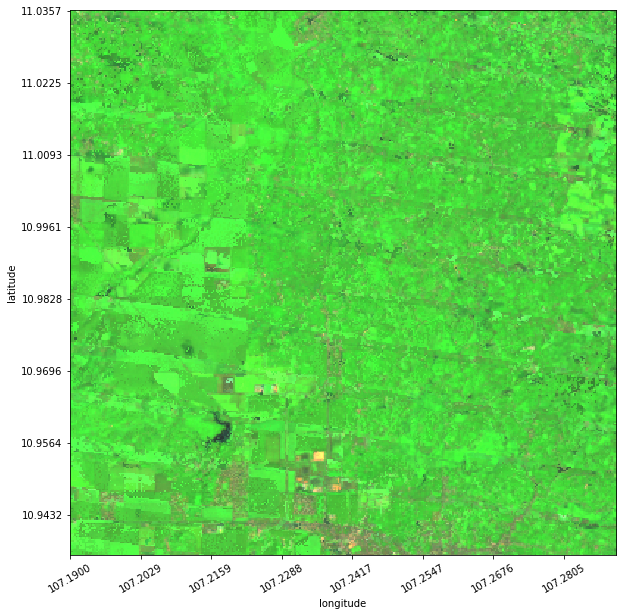

In [20]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

max_ndvi_composite = create_max_ndvi_mosaic(cleaned_dataset, cloud_mask.values)
rgb(max_ndvi_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=4000, width=10)
plt.show()

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

In [21]:
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

<p style="color:red";><b>CHANGE INPUTS BELOW

In [22]:
# Remove the comment tags (#) to export a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 

export_slice_to_geotiff(median_composite, '../output/geotiffs/DEMO_median_composite.tif')
# export_slice_to_geotiff(geomedian_composite, '../output/geotiffs/DEMO_geomedian_composite.tif')
# export_slice_to_geotiff(most_recent_composite, '../output/geotiffs/DEMO_most_recent_composite.tif')
# export_slice_to_geotiff(max_ndvi_composite, '../output/geotiffs/DEMO_max_ndvi_composite.tif')

In [23]:
!ls -lah ../output/geotiffs/

total 4.8M
drwxrwxr-x 8 localuser localuser 4.0K Jun 28 15:12 .
drwxrwxr-x 5 localuser localuser 4.0K Jun 25 22:37 ..
drwxrwxr-x 2 localuser localuser 4.0K Jun 25 22:41 .ipynb_checkpoints
drwxrwxr-x 2 localuser localuser 4.0K Jun 25 21:00 Clustering_Notebook
drwxrwxr-x 2 localuser localuser 4.0K Jun 25 21:01 DCAL_Custom_Mosaics_and_Shapefiles
-rw-rw-r-- 1 localuser localuser 3.7M Jun 28 15:12 DEMO_median_composite.tif
drwxrwxr-x 2 localuser localuser 4.0K Jun 26 21:19 NDVI_Phenology
drwxrwxr-x 2 localuser localuser 4.0K Jun 25 22:47 landsat7
drwxrwxr-x 3 localuser localuser 4.0K Jun 25 22:26 landsat8
-rw-rw-r-- 1 localuser localuser 337K Jun 28 14:39 sample_anomaly_01.tif
-rw-rw-r-- 1 localuser localuser 674K Jun 28 14:45 wofs.tif
